In [ ]:
import tensorflow as tf


class Generator(tf.keras.Model):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.d1 = tf.keras.layers.Dense(1024, use_bias=False)
        self.a1 = tf.keras.layers.ReLU()
        self.b1 = tf.keras.layers.BatchNormalization()\
        
        self.d2 = tf.keras.layers.Dense(7*7*128, use_bias=False)
        self.a2 = tf.keras.layers.ReLU()
        self.b2 = tf.keras.layers.BatchNormalization()
        self.r2 = tf.keras.layers.Reshape([7, 7, 128])
        
        self.c3 = tf.keras.layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding="same")
        self.a3 = tf.keras.layers.ReLU()
        self.b3 = tf.keras.layers.BatchNormalization()
        
        self.c4 = tf.keras.layers.Conv2DTranspose(1, (4, 4), strides=(2, 2), padding="same")
        
    def call(self, x, training=True):
        x = self.d1(x)
        x = self.b1(x, training=training)
        x = self.a1(x)
        
        
        x = self.d2(x)
        x = self.b2(x, training=training)
        x = self.a2(x)
        x = self.r2(x)
        
        x = self.c3(x)
        x = self.b3(x, training=training)
        x = self.a3(x)
           
        x = self.c4(x)
        
        x = tf.nn.tanh(x)
        
        return x
    
class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.c1 = tf.keras.layers.Conv2D(64, (4, 4), strides=(2, 2), padding="same")
        self.a1 = tf.keras.layers.LeakyReLU()
        
        self.c2 = tf.keras.layers.Conv2D(128, (4, 4), strides=(2, 2), padding="same")
        self.a2 = tf.keras.layers.LeakyReLU()
        self.b2 = tf.keras.layers.BatchNormalization()
        self.f2 = tf.keras.layers.Flatten()
        
        self.d3 = tf.keras.layers.Dense(1024)
        self.a3 = tf.keras.layers.LeakyReLU()
        self.b3 = tf.keras.layers.BatchNormalization()
        
        self.D = tf.keras.layers.Dense(1)
        
    def call(self, x, training=True):
        x = self.c1(x)
        x = self.a1(x)
        
        x = self.c2(x)
        x = self.b2(x, training=training)
        x = self.a2(x)
        x = self.f2(x)
        
        x = self.d3(x)
        x = self.b3(x, training=training)
        x = self.a3(x)
        
        mid = x
        
        D = self.D(x)   
        
        return D, mid
    
class QNet(tf.keras.Model):
    def __init__(self):
        super(QNet, self).__init__()
        
        self.Qd = tf.keras.layers.Dense(128)
        self.Qb = tf.keras.layers.BatchNormalization()
        self.Qa = tf.keras.layers.LeakyReLU()
        
        self.Q_cat = tf.keras.layers.Dense(10)
        self.Q_con1_mu = tf.keras.layers.Dense(2)
        self.Q_con1_var = tf.keras.layers.Dense(2)
        self.Q_con2_mu = tf.keras.layers.Dense(2)
        self.Q_con2_var = tf.keras.layers.Dense(2)
        
    def sample(self, mu, var):
        eps = tf.random.normal(shape=mu.shape)
        sigma = tf.sqrt(var)
        z = mu + sigma * eps
        
        return z
    
    def call(self, x, training=True):
        q = self.Qd(x)
        
        q = self.Qb(q, training=training)
        q = self.Qa(q)
        
        Q_cat = self.Q_cat(q)

        Q_con1_mu = self.Q_con1_mu(q)
        Q_con1_var = tf.exp(self.Q_con1_var(q))
        Q_con2_mu = self.Q_con2_mu(q)
        Q_con2_var = tf.exp(self.Q_con2_var(q))
        
        Q_con1 = self.sample(Q_con1_mu, Q_con1_var)
        Q_con2 = self.sample(Q_con2_mu, Q_con2_var)
        
        return Q_cat, Q_con1, Q_con2

    
if __name__ == "__main__":
    import numpy as np
    
    z = np.random.normal(size=(1, 74)).astype(np.float32)
    z = tf.convert_to_tensor(z)
    
    g = Generator()
    d = Discriminator()
    image = g(z)
    prediction = d(image)

        

1 Generator: 1.1156	Discriminator: 0.9394
2 Generator: 1.2323	Discriminator: 0.8532
3 Generator: 1.1765	Discriminator: 0.9110
4 Generator: 1.1349	Discriminator: 0.9561
5 Generator: 1.1056	Discriminator: 0.9874
6 Generator: 1.0842	Discriminator: 1.0118
7 Generator: 1.0677	Discriminator: 1.0298
8 Generator: 1.0546	Discriminator: 1.0450
9 Generator: 1.0426	Discriminator: 1.0586
10 Generator: 1.0325	Discriminator: 1.0700
11 Generator: 1.0232	Discriminator: 1.0806
12 Generator: 1.0151	Discriminator: 1.0897
13 Generator: 1.0078	Discriminator: 1.0982
14 Generator: 1.0016	Discriminator: 1.1047
15 Generator: 0.9965	Discriminator: 1.1100
16 Generator: 0.9921	Discriminator: 1.1151
17 Generator: 0.9888	Discriminator: 1.1190
18 Generator: 0.9855	Discriminator: 1.1227
19 Generator: 0.9830	Discriminator: 1.1255
20 Generator: 0.9815	Discriminator: 1.1275
21 Generator: 0.9807	Discriminator: 1.1288
22 Generator: 0.9804	Discriminator: 1.1296
23 Generator: 0.9804	Discriminator: 1.1300
24 Generator: 0.9811

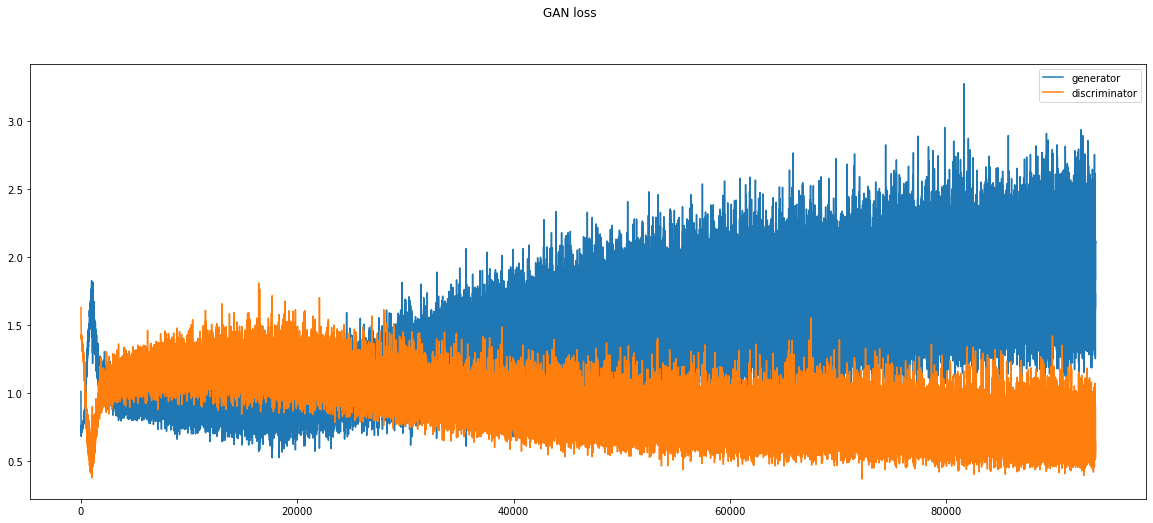

In [ ]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow_probability import distributions as tfd

BATCH_SIZE = 64

(Xtr, ytr), (_, _) = tf.keras.datasets.mnist.load_data()
Xtr = (Xtr / 127.5) - 1
Xtr = Xtr.reshape([60000, 28, 28, 1]).astype("float32")

dataset = tf.data.Dataset.from_tensor_slices(Xtr).shuffle(30000).batch(BATCH_SIZE)

discriminator = Discriminator()
generator = Generator()
qnet = QNet()

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
gen_opt = tf.keras.optimizers.Adam(1e-3)
dis_opt = tf.keras.optimizers.Adam(2e-4)

writer = tf.summary.create_file_writer("./infogan")
checkpoint_dir = './ckpt'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=gen_opt,
                                 discriminator_optimizer=dis_opt,
                                 generator=generator,
                                 discriminator=discriminator,
                                 qnet=qnet)

def train_display_image(model, epoch):
    z1, _, _, _ = sample(4, 0)
    z2, _, _, _ = sample(4, 1)
    z3, _, _, _ = sample(4, 2)
    z4, _, _, _ = sample(4, 3)
    z = tf.concat([z1,z2,z3,z4], axis=0)
    predictions = model(z, training=False)
    predictions = (predictions + 1.) / 2.

    plt.figure(figsize=(4,4))
    plt.suptitle(epoch+1)
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(tf.reshape(predictions[i], [28, 28]), cmap='gray')
        plt.axis("off")
        
    plt.savefig('train_images/img_step{:04d}.png'.format(epoch))
    plt.close()

def discriminator_loss(real, fake):
    real_loss = cross_entropy(tf.ones_like(real), real)
    fake_loss = cross_entropy(tf.zeros_like(fake), fake)
    
    total_loss = real_loss + fake_loss
    
    return total_loss

def generator_loss(fake):
    loss = cross_entropy(tf.ones_like(fake), fake)
    
    return loss

def get_mi(fqcon1, fqcon2, fqcat, z_con1, z_con2, z_cat):
    
    c1 = tf.reduce_mean(tf.reduce_sum(tf.square(fqcon1 - z_con1), -1)) * 0.5
    c2 = tf.reduce_mean(tf.reduce_sum(tf.square(fqcon2 - z_con2), -1)) * 0.5
    sce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)(z_cat, fqcat)

    info_loss = c1 + c2 + sce
    
    return info_loss, c1, c2, sce

def sample(size, cat=-1, c1=None, c2=None):
    z = tfd.Uniform(low=-1.0, high=1.0).sample([size, 62])
    
    if c1 is not None:
        z_con1 = np.array([c1] * size)
        z_con1 = np.reshape(z_con1, [size, 1])
    else:
        z_con1 = tfd.Uniform(low=-1.0, high=1.0).sample([size, 1])
        
    if c2 is not None:
        z_con2 = np.array([c2] * size)
        z_con2 = np.reshape(z_con2, [size, 1])
    else:
        z_con2 = tfd.Uniform(low=-1.0, high=1.0).sample([size, 1])
        
    if cat >= 0:
        z_cat = np.array([cat] * size)
        z_cat = tf.one_hot(z_cat, 10)
    else:
        z_cat = tfd.Categorical(probs=tf.ones([10])*0.1).sample([size,])
        z_cat = tf.one_hot(z_cat, 10)
    
    noise = tf.concat([z, z_con1, z_con2, z_cat], axis=-1)
    
    return noise, z_con1, z_con2, z_cat

def train_step(images, step):
    
    noise, z_con1, z_con2, z_cat = sample(BATCH_SIZE)
    with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
        generated_images = generator(noise, training=True)
        
        real_output, _ = discriminator(images, training=True)
        fake_output, mid = discriminator(generated_images, training=True)
        fqcat, fqcon1, fqcon2 = qnet(mid)

        info_loss, c1, c2, sce = get_mi(fqcon1, fqcon2, fqcat, z_con1, z_con2, z_cat)
        
        gen_loss = generator_loss(fake_output) 
        dis_loss = discriminator_loss(real_output, fake_output)
        
        gi = gen_loss + info_loss
        di = dis_loss + info_loss
    
    with writer.as_default():
        tf.summary.scalar("discriminator", dis_loss, step)
        tf.summary.scalar("generator", gen_loss, step)
        tf.summary.scalar("c1", c1, step)
        tf.summary.scalar("c2", c2, step)
        tf.summary.scalar("sce", sce, step)
        
    gen_grd = gen_tape.gradient(gi, generator.trainable_variables + qnet.trainable_variables)
    dis_grd = dis_tape.gradient(di, discriminator.trainable_variables)
    
    gen_opt.apply_gradients(zip(gen_grd, generator.trainable_variables))
    dis_opt.apply_gradients(zip(dis_grd, discriminator.trainable_variables))
    
    return gen_loss, dis_loss


def train(dataset, epochs):
    step = 0
    gen_loss = []
    dis_loss = []
    for epoch in range(epochs): 
        for batch in dataset:
            gen, dis = train_step(batch, step)
            writer.flush()
            gen_loss.append(gen)
            dis_loss.append(dis)
            
            step += 1
            
            if step%100 == 0:
                train_display_image(generator, step)
        
        checkpoint.save(file_prefix=checkpoint_prefix)
        g_loss = tf.reduce_mean(gen_loss).numpy()
        d_loss = tf.reduce_mean(dis_loss).numpy()
        
        print("{} Generator: {:.4f}\tDiscriminator: {:.4f}".format(epoch+1, g_loss, d_loss))
        
        
    plt.figure(figsize=(20, 8))
    plt.plot(gen_loss, label="generator")
    plt.plot(dis_loss, label="discriminator")
    plt.legend()
    plt.suptitle("GAN loss")
    plt.savefig("GAN loss")

if __name__ == "__main__":
    train(dataset, 100)
